## Uses the corrected dataset
corrected datasets also divides the celebrities directly into train/test/val, to avoid identity leakage.

In [1]:
import torch

In [2]:
from torchvision import transforms

train_tf = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply([transforms.ColorJitter(0.25, 0.25, 0.25, 0.05)], p=0.8),
        transforms.RandomApply(
            [
                transforms.RandomAffine(
                    degrees=10,  # small rotation
                    translate=(0.05, 0.05),  # small shifts
                    scale=(0.9, 1.1),
                )
            ],
            p=0.5,
        ),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2),
        transforms.ToTensor(),
        transforms.RandomErasing(
            p=0.25, scale=(0.02, 0.1), ratio=(0.3, 3.3), value="random"
        ),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

val_tf = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

In [3]:
from torch.utils.data import DataLoader
from dataset import IDSplitCelebMBTIMultiTargetDataset

train_ds = IDSplitCelebMBTIMultiTargetDataset(
    root_dir="faces_yolo_id_split",
    metadata_csv="faces_yolo_id_split_metadata.csv",
    split="train",
    transform=train_tf,
)

val_ds = IDSplitCelebMBTIMultiTargetDataset(
    root_dir="faces_yolo_id_split",
    metadata_csv="faces_yolo_id_split_metadata.csv",
    split="val",
    transform=val_tf,
)

test_ds = IDSplitCelebMBTIMultiTargetDataset(  
    root_dir="faces_yolo_id_split",
    metadata_csv="faces_yolo_id_split_metadata.csv",
    split="test",
    transform=val_tf,
)

print(len(train_ds), len(val_ds), len(test_ds))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=4)

for images, labels in train_loader:
    print(images.shape)  # [Batch, 3, 224, 224]
    print(labels.shape)  # [Batch, 4]
    break

9573 1201 1205
torch.Size([32, 3, 224, 224])
torch.Size([32, 4])


In [4]:
import torch.nn as nn
from models import MBTIMultiHeadAffectNetPretrained

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
history = {
    "train_loss_ie": [],
    "train_loss_ns": [],
    "train_loss_tf": [],
    "train_loss_jp": [],
    
    "val_loss_ie": [],
    "val_loss_ns": [],
    "val_loss_tf": [],
    "val_loss_jp": [],
    # We can still track global accuracy if you like
    "train_acc": [],
    "val_acc": [],

    "train_loss_ie": [],
    "train_loss_ns": [],
    "train_loss_tf": [],
    "train_loss_jp": [],

    'val_acc_ie': [],
    'val_acc_ns': [],
    'val_acc_tf': [],
    'val_acc_jp': []
}

trait_names = ["ie", "ns", "tf", "jp"]

In [6]:
from tqdm import tqdm

def train_one_epoch(
    model, train_loader, val_loader, criterion, optimizer, device, history, epoch
):
    trait_names = ["ie", "ns", "tf", "jp"]

    # --- TRAINING PHASE ---
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch:02d} [train]", leave=False)

    train_head_losses = [0.0, 0.0, 0.0, 0.0]
    train_correct_bits = 0
    train_total_bits = 0
    train_total_samples = 0

    for x, y in pbar:
        x = x.to(device)
        y = y.to(device).float()

        optimizer.zero_grad()
        logits = model(x)

        # Calculate Loss (reduction='none' gives [Batch, 4])
        raw_loss = criterion(logits, y)

        # Backprop on mean scalar
        loss_for_backprop = raw_loss.mean()
        loss_for_backprop.backward()
        optimizer.step()

        # Track Per-Head Loss
        batch_head_losses = raw_loss.mean(dim=0)  # Shape [4]
        for i in range(4):
            train_head_losses[i] += batch_head_losses[i].item() * y.size(0)

        # Track Global Training Accuracy
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
        train_correct_bits += (preds == y).sum().item()
        train_total_bits += y.numel()
        train_total_samples += y.size(0)

        pbar.set_postfix(loss=loss_for_backprop.item())

    # Store Training Metrics
    tr_acc = train_correct_bits / train_total_bits
    history["train_acc"].append(tr_acc)

    for i, name in enumerate(trait_names):
        avg_loss = train_head_losses[i] / train_total_samples
        history[f"train_loss_{name}"].append(avg_loss)

    # --- VALIDATION PHASE ---
    model.eval()
    pbar = tqdm(val_loader, desc=f"Epoch {epoch:02d} [val]", leave=False)

    val_head_losses = [0.0, 0.0, 0.0, 0.0]
    val_head_correct = [0, 0, 0, 0]  # Accumulator for correct predictions per head

    val_correct_bits = 0
    val_total_bits = 0
    val_total_samples = 0

    with torch.no_grad():
        for x, y in pbar:
            x = x.to(device)
            y = y.to(device).float()

            logits = model(x)
            raw_loss = criterion(logits, y)

            # 1. Track Per-Head Loss
            batch_head_losses = raw_loss.mean(dim=0)
            for i in range(4):
                val_head_losses[i] += batch_head_losses[i].item() * y.size(0)

            # 2. Generate Predictions
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()

            # 3. Track Global Accuracy
            val_correct_bits += (preds == y).sum().item()
            val_total_bits += y.numel()

            # 4. Track Per-Head Accuracy (The New Part)
            # (preds == y) results in [Batch, 4] boolean matrix
            # .sum(dim=0) gives us correct count for each column [c_ie, c_ns, c_tf, c_jp]
            correct_counts = (preds == y).sum(dim=0)
            for i in range(4):
                val_head_correct[i] += correct_counts[i].item()

            val_total_samples += y.size(0)

    # --- FINAL CALCULATIONS & LOGGING ---
    va_acc = val_correct_bits / val_total_bits
    history["val_acc"].append(va_acc)

    loss_msg = []
    acc_msg = []

    for i, name in enumerate(trait_names):
        # Loss per head
        avg_loss = val_head_losses[i] / val_total_samples
        history[f"val_loss_{name}"].append(avg_loss)

        # Acc per head
        avg_acc = val_head_correct[i] / val_total_samples
        history[f"val_acc_{name}"].append(avg_acc)

        loss_msg.append(f"{name.upper()}:{avg_loss:.2f}")
        acc_msg.append(f"{name.upper()}:{avg_acc:.2f}")

    print(
        f"Epoch {epoch:02d} | Global Tr Acc: {tr_acc:.3f} | Global Val Acc: {va_acc:.3f}"
    )
    print(f"   Val Loss -> {' '.join(loss_msg)}")
    print(f"   Val Acc  -> {' '.join(acc_msg)}")

In [7]:
model = MBTIMultiHeadAffectNetPretrained(freeze_backbone=True)

FROZEN_NUM_EPOCHS = 8
UNFROZEN_NUM_EPOCHS = 50

model.to(device)
criterion = nn.BCEWithLogitsLoss(reduction="none")
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4
)

for epoch in range(1, FROZEN_NUM_EPOCHS + 1):
    train_one_epoch(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        device,
        history,
        epoch,
    )

Epoch 01 | Global Tr Acc: 0.549 | Global Val Acc: 0.586
   Val Loss -> IE:0.68 NS:0.68 TF:0.67 JP:0.68
   Val Acc  -> IE:0.59 NS:0.57 TF:0.61 JP:0.57


Epoch 02 | Global Tr Acc: 0.575 | Global Val Acc: 0.579
   Val Loss -> IE:0.68 NS:0.68 TF:0.68 JP:0.68
   Val Acc  -> IE:0.58 NS:0.58 TF:0.59 JP:0.57


Epoch 03 | Global Tr Acc: 0.583 | Global Val Acc: 0.581
   Val Loss -> IE:0.68 NS:0.68 TF:0.68 JP:0.67
   Val Acc  -> IE:0.59 NS:0.57 TF:0.58 JP:0.58


Epoch 04 | Global Tr Acc: 0.587 | Global Val Acc: 0.588
   Val Loss -> IE:0.67 NS:0.68 TF:0.67 JP:0.68
   Val Acc  -> IE:0.60 NS:0.57 TF:0.60 JP:0.58


Epoch 05 | Global Tr Acc: 0.592 | Global Val Acc: 0.582
   Val Loss -> IE:0.68 NS:0.68 TF:0.68 JP:0.68
   Val Acc  -> IE:0.59 NS:0.57 TF:0.58 JP:0.58


Epoch 06 | Global Tr Acc: 0.592 | Global Val Acc: 0.585
   Val Loss -> IE:0.67 NS:0.68 TF:0.67 JP:0.68
   Val Acc  -> IE:0.60 NS:0.58 TF:0.59 JP:0.57


Epoch 07 | Global Tr Acc: 0.597 | Global Val Acc: 0.582
   Val Loss -> IE:0.68 NS:0.68 TF:0.67 JP:0.67
   Val Acc  -> IE:0.58 NS:0.59 TF:0.59 JP:0.57


Epoch 08 | Global Tr Acc: 0.596 | Global Val Acc: 0.581
   Val Loss -> IE:0.68 NS:0.68 TF:0.67 JP:0.67
   Val Acc  -> IE:0.57 NS:0.59 TF:0.58 JP:0.57


In [8]:
# unfreeze the backbone for fine-tuning
for param in model.backbone.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-2)
for epoch in range(1, UNFROZEN_NUM_EPOCHS + 1):
    train_one_epoch(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        device,
        history,
        epoch,
    )

Epoch 01 | Global Tr Acc: 0.602 | Global Val Acc: 0.582
   Val Loss -> IE:0.68 NS:0.67 TF:0.67 JP:0.68
   Val Acc  -> IE:0.58 NS:0.58 TF:0.59 JP:0.57


Epoch 02 | Global Tr Acc: 0.617 | Global Val Acc: 0.581
   Val Loss -> IE:0.67 NS:0.68 TF:0.67 JP:0.68
   Val Acc  -> IE:0.59 NS:0.58 TF:0.58 JP:0.56


Epoch 03 | Global Tr Acc: 0.623 | Global Val Acc: 0.585
   Val Loss -> IE:0.67 NS:0.68 TF:0.67 JP:0.68
   Val Acc  -> IE:0.59 NS:0.58 TF:0.59 JP:0.58


Epoch 04 | Global Tr Acc: 0.631 | Global Val Acc: 0.589
   Val Loss -> IE:0.68 NS:0.67 TF:0.67 JP:0.68
   Val Acc  -> IE:0.59 NS:0.59 TF:0.59 JP:0.59


Epoch 05 | Global Tr Acc: 0.641 | Global Val Acc: 0.583
   Val Loss -> IE:0.68 NS:0.68 TF:0.67 JP:0.68
   Val Acc  -> IE:0.58 NS:0.58 TF:0.59 JP:0.58


Epoch 06 | Global Tr Acc: 0.650 | Global Val Acc: 0.582
   Val Loss -> IE:0.68 NS:0.68 TF:0.67 JP:0.69
   Val Acc  -> IE:0.58 NS:0.59 TF:0.58 JP:0.57


Epoch 07 | Global Tr Acc: 0.664 | Global Val Acc: 0.578
   Val Loss -> IE:0.69 NS:0.70 TF:0.68 JP:0.69
   Val Acc  -> IE:0.59 NS:0.58 TF:0.59 JP:0.57


Epoch 08 | Global Tr Acc: 0.674 | Global Val Acc: 0.584
   Val Loss -> IE:0.68 NS:0.69 TF:0.68 JP:0.69
   Val Acc  -> IE:0.59 NS:0.59 TF:0.59 JP:0.58


Epoch 09 | Global Tr Acc: 0.687 | Global Val Acc: 0.572
   Val Loss -> IE:0.69 NS:0.72 TF:0.69 JP:0.70
   Val Acc  -> IE:0.59 NS:0.57 TF:0.58 JP:0.55


Epoch 10 | Global Tr Acc: 0.700 | Global Val Acc: 0.575
   Val Loss -> IE:0.70 NS:0.71 TF:0.69 JP:0.70
   Val Acc  -> IE:0.58 NS:0.58 TF:0.58 JP:0.56


Epoch 11 | Global Tr Acc: 0.713 | Global Val Acc: 0.577
   Val Loss -> IE:0.71 NS:0.71 TF:0.69 JP:0.72
   Val Acc  -> IE:0.58 NS:0.58 TF:0.59 JP:0.56


Epoch 12 | Global Tr Acc: 0.723 | Global Val Acc: 0.575
   Val Loss -> IE:0.72 NS:0.73 TF:0.71 JP:0.73
   Val Acc  -> IE:0.57 NS:0.58 TF:0.58 JP:0.57


Epoch 13 | Global Tr Acc: 0.737 | Global Val Acc: 0.573
   Val Loss -> IE:0.72 NS:0.72 TF:0.72 JP:0.74
   Val Acc  -> IE:0.57 NS:0.58 TF:0.59 JP:0.55


Epoch 14 | Global Tr Acc: 0.756 | Global Val Acc: 0.567
   Val Loss -> IE:0.73 NS:0.75 TF:0.72 JP:0.75
   Val Acc  -> IE:0.57 NS:0.57 TF:0.58 JP:0.55


Epoch 15 | Global Tr Acc: 0.769 | Global Val Acc: 0.572
   Val Loss -> IE:0.74 NS:0.75 TF:0.73 JP:0.75
   Val Acc  -> IE:0.56 NS:0.59 TF:0.58 JP:0.57


Epoch 16 | Global Tr Acc: 0.782 | Global Val Acc: 0.568
   Val Loss -> IE:0.74 NS:0.78 TF:0.75 JP:0.78
   Val Acc  -> IE:0.56 NS:0.57 TF:0.57 JP:0.57


Epoch 17 | Global Tr Acc: 0.794 | Global Val Acc: 0.566
   Val Loss -> IE:0.75 NS:0.77 TF:0.77 JP:0.78
   Val Acc  -> IE:0.56 NS:0.57 TF:0.58 JP:0.55


KeyboardInterrupt: 

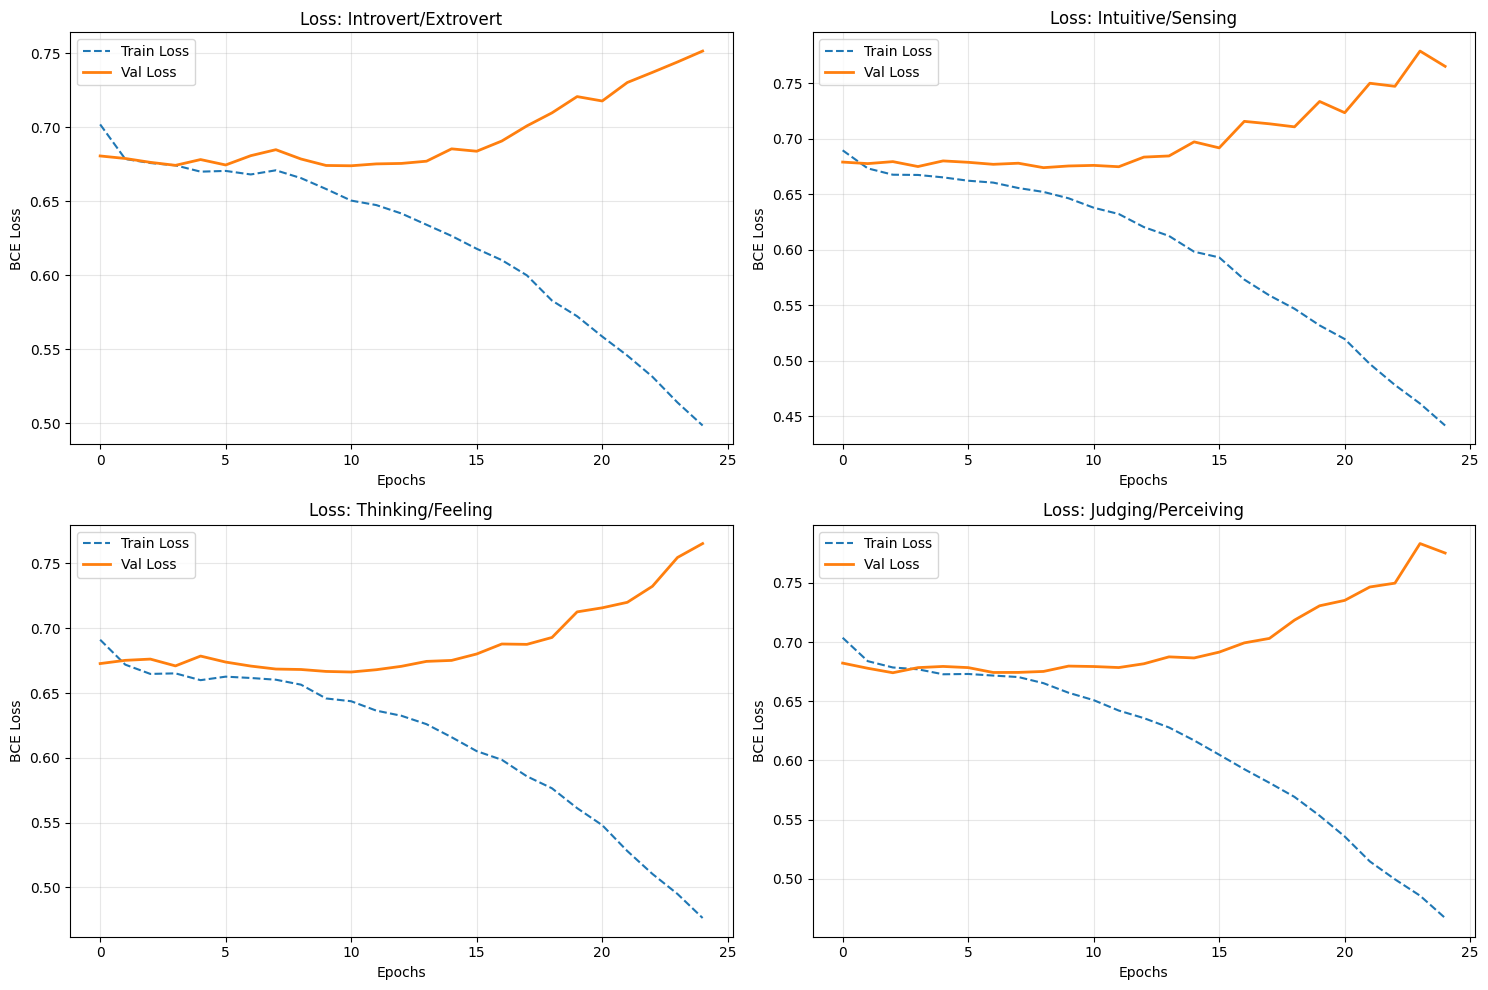

In [9]:
import matplotlib.pyplot as plt


def plot_per_head_history(history):
    epochs = range(len(history["train_acc"]))
    traits = ["ie", "ns", "tf", "jp"]
    titles = [
        "Introvert/Extrovert",
        "Intuitive/Sensing",
        "Thinking/Feeling",
        "Judging/Perceiving",
    ]

    plt.figure(figsize=(15, 10))

    for i, trait in enumerate(traits):
        plt.subplot(2, 2, i + 1)

        # Plot Train vs Val for this specific trait
        plt.plot(
            epochs, history[f"train_loss_{trait}"], label=f"Train Loss", linestyle="--"
        )
        plt.plot(epochs, history[f"val_loss_{trait}"], label=f"Val Loss", linewidth=2)

        plt.title(f"Loss: {titles[i]}")
        plt.xlabel("Epochs")
        plt.ylabel("BCE Loss")
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# Call it after training
plot_per_head_history(history)

In [10]:
from sklearn.metrics import roc_auc_score
import numpy as np

# Add to history
history["val_auc_ie"] = []
history["val_auc_ns"] = []
history["val_auc_tf"] = []
history["val_auc_jp"] = []

# --- VALIDATION PHASE ---
model.eval()

test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, num_workers=4)
pbar = tqdm(test_loader, desc=f"Epoch {epoch:02d} [val]", leave=False)

# Containers to hold the ENTIRE validation set's data
all_val_targets = []
all_val_probs = []

val_head_losses = [0.0, 0.0, 0.0, 0.0]
val_total_samples = 0

with torch.no_grad():
    for x, y in pbar:
        x = x.to(device)
        y = y.to(device).float()

        logits = model(x)

        # Calculate Loss as before
        raw_loss = criterion(logits, y)
        batch_head_losses = raw_loss.mean(dim=0)
        for i in range(4):
            val_head_losses[i] += batch_head_losses[i].item() * y.size(0)

        val_total_samples += y.size(0)

        # --- STORE PREDICTIONS FOR AUC ---
        probs = torch.sigmoid(logits)

        # Move to CPU and store in list
        all_val_targets.append(y.cpu())
        all_val_probs.append(probs.cpu())

val_targets_np = torch.cat(all_val_targets).numpy()
val_probs_np = torch.cat(all_val_probs).numpy()

aucs = []
trait_names = ["ie", "ns", "tf", "jp"]

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np


def plot_mbti_roc_curves(val_targets, val_probs, epoch_num):
    """
    Args:
        val_targets: numpy array of shape [N_samples, 4] (Ground Truth)
        val_probs: numpy array of shape [N_samples, 4] (Probabilities 0.0 - 1.0)
        epoch_num: Current epoch (for title)
    """
    trait_names = [
        "Introvert vs Extrovert (IE)",
        "Intuitive vs Sensing (NS)",
        "Thinking vs Feeling (TF)",
        "Judging vs Perceiving (JP)",
    ]

    plt.figure(figsize=(10, 8))

    # Iterate through each of the 4 traits
    for i in range(4):
        # Get the Truth and Score for JUST this trait column
        y_true = val_targets[:, i]
        y_score = val_probs[:, i]

        # Calculate ROC points
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)

        # Plot
        plt.plot(fpr, tpr, lw=2, label=f"{trait_names[i]} (AUC = {roc_auc:.2f})")

    # Add the diagonal "Random Guess" line
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random Guess")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate (False Alarms)")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title(f"MBTI ROC Curves - Epoch {epoch_num}")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

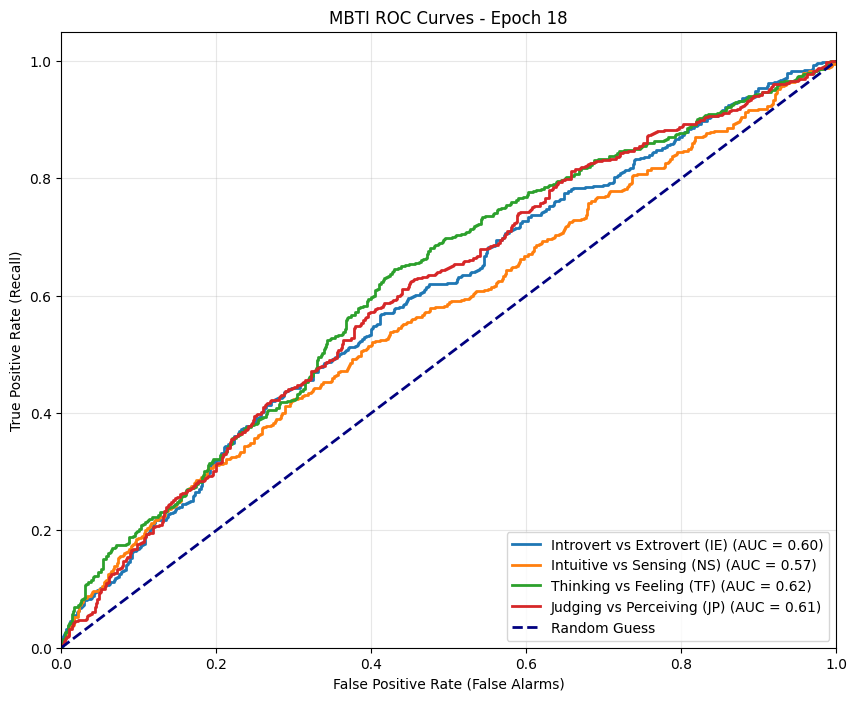

In [12]:
plot_mbti_roc_curves(val_targets_np, val_probs_np, epoch)

In [ ]:
# torch.save(model.state_dict(), "pretrained_multihead_30epochs.pth")